In [ ]:
!pip install d2l==0.16.1

## 1. Sequence Data


## Training

After reviewing so many statistical tools,
let us try this out in practice.
We begin by generating some data.
To keep things simple we generate our sequence data by using a sine function with some additive noise for time steps $1, 2, \ldots, 1000$.


In [2]:
%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn

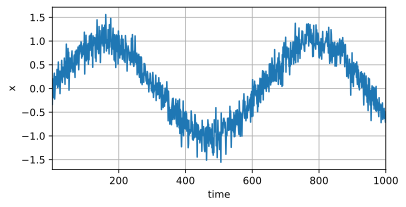

In [3]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Next, we need to turn such a sequence into features and labels that our model can train on.
Based on the embedding dimension $\tau$ we map the data into pairs $y_t = x_t$ and $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.
The astute reader might have noticed that this gives us $\tau$ fewer data examples, since we do not have sufficient history for the first $\tau$ of them.
A simple fix, in particular if the sequence is long,
is to discard those few terms.
Alternatively we could pad the sequence with zeros.
Here we only use the first 600 feature-label pairs for training.


In [4]:
tau = 16
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [5]:
batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

Here we keep the architecture fairly simple:
just an MLP with two fully-connected layers, ReLU activation, and squared loss.


In [8]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(16, 20),
                        nn.ReLU(),
                        nn.Linear(20, 1))
    net.apply(init_weights)
    return net

# Square loss
loss = nn.MSELoss()

Now we are ready to train the model. 


In [10]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 15, 0.01)

epoch 1, loss: 0.061927
epoch 2, loss: 0.058099
epoch 3, loss: 0.053969
epoch 4, loss: 0.051197
epoch 5, loss: 0.046418
epoch 6, loss: 0.048615
epoch 7, loss: 0.045689
epoch 8, loss: 0.045830
epoch 9, loss: 0.048268
epoch 10, loss: 0.045315
epoch 11, loss: 0.047299
epoch 12, loss: 0.047054
epoch 13, loss: 0.048906
epoch 14, loss: 0.050158
epoch 15, loss: 0.044995


## Prediction

Since the training loss is small, we would expect our model to work well. Let us see what this means in practice. The first thing to check is how well the model is able to predict what happens just in the next time step,
namely the *one-step-ahead prediction*.


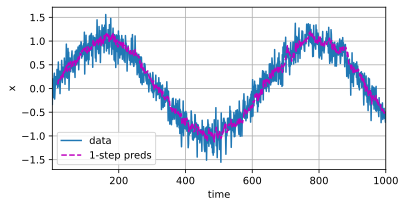

In [11]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()],
    'time',
    'x',
    legend=['data', '1-step preds'],
    xlim=[1, 1000],
    figsize=(6, 3))

The one-step-ahead predictions look nice, just as we expected.
Even beyond 604 (`n_train + tau`) observations the predictions still look trustworthy.
However, there is just one little problem to this:
if we observe sequence data only until time step 604, we cannot hope to receive the inputs for all the future one-step-ahead predictions.
Instead, we need to work our way forward one step at a time:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

Generally, for an observed sequence up to $x_t$, its predicted output $\hat{x}_{t+k}$ at time step $t+k$ is called the *$k$-step-ahead prediction*. Since we have observed up to $x_{604}$, its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to use our own predictions to make multistep-ahead predictions.
Let us see how well this goes.


In [12]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

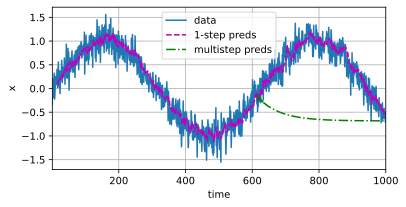

In [13]:
d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()
],
         'time',
         'x',
         legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000],
         figsize=(6, 3))

As the above example shows, this is a spectacular failure. The predictions decay to a constant pretty quickly after a few prediction steps.
Why did the algorithm work so poorly?
This is ultimately due to the fact that the errors build up.
Let us say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \bar\epsilon + c \epsilon_1$ for some constant $c$, and so on. The error can diverge rather rapidly from the true observations. This is a common phenomenon. For instance, weather forecasts for the next 24 hours tend to be pretty accurate but beyond that the accuracy declines rapidly. We will discuss methods for improving this throughout this chapter and beyond.

Let us take a closer look at the difficulties in $k$-step-ahead predictions
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


In [15]:
max_steps = 64

In [16]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

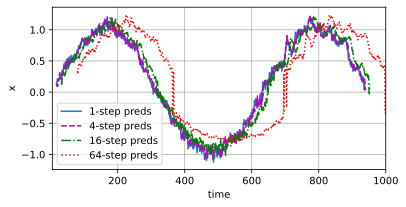

In [17]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps],
         'time',
         'x',
         legend=[f'{i}-step preds' for i in steps],
         xlim=[5, 1000],
         figsize=(6, 3))